# Loading data and preprocessing

In [1]:
%%capture
%run "preprocessing.ipynb"

In [2]:
df_proc = df_proc # type: ignore

# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

# Dividing data over intervals

Grouping customers by "Year" and "Month"

In [4]:
df_09 = df_proc.groupby(["Year", "Month"]).get_group((2009, 12))

In [5]:
df_09.head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Day,Month,Year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,12,2009


In [6]:
df_10 = []
for i in range(1, 13):
    df_10.append(df_proc.groupby(["Year", "Month"]).get_group((2010, i)))

In [7]:
df_10[0].head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Day,Month,Year
31760,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.5,12346.0,United Kingdom,4,1,2010


Funny catch there are some entries are made as test. But they are less than 20 entries anyways. 

In [8]:
df_11 = []
for i in range(1, 13):
    df_11.append(df_proc.groupby(["Year", "Month"]).get_group((2011, i)))

In [9]:
df_11[0].head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Day,Month,Year
444384,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,4,1,2011


In [10]:
df_proc.groupby(["Year", "Month"]).count()[["Invoice"]]

Invoice
Year Month         
2009 12       26518
2010 1        18845
     2        20306
     3        27932
     4        22953
     5        23909
     6        26227
     7        23045
     8        22467
     9        29438
     10       42442
     11       51936
     12       34588
2011 1        17678
     2        16581
     3        22720
     4        19003
     5        23305
     6        22484
     7        22587
     8        22623
     9        34195
     10       42770
     11       56441
     12       15030

In [11]:
df_t = [df_09] + df_10 + df_11

In [12]:
df_t[0].head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Day,Month,Year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,12,2009


In [13]:
def centers_ranking(centers):
    center_scores = {}
    for i, c in enumerate(centers):
        # Ranking equation
        # Score = a Monetary + b Frequency - c Recency
        center_scores[i] = c[2] + c[1] - c[0]
        # {'0': 1, '1': 2, '2': 3}
    # Sort the centers by the score
    sorted_cs = sorted(center_scores.items(), key=lambda x: x[1])
    # [('0': 1),('1': 2),('2': 3)]
    # Ranking the dictionary
    for i, e in enumerate(sorted_cs):
        center_scores[e[0]] = i
    # print(center_scores)
    return center_scores

In [14]:
rfms = []
for i in range(len(df_t)):
    
    # Recency
    max_date = df_t[i]['InvoiceDate'].max()
    df_t[i]['Diff'] = max_date - df_t[i].loc[:,'InvoiceDate']
    rfm_r = df_t[i].groupby('Customer ID')['Diff'].min().reset_index()
    rfm_r['Diff'] = rfm_r['Diff'].dt.days
    rfm_r.columns =  ['Customer ID', 'Recency']

    # Frequency
    rfm_f = df_t[i].groupby('Customer ID')['Invoice'].count().reset_index()
    rfm_f.columns = ['Customer ID', 'Frequency']

    # Monetary 
    df_t[i]['Total'] = df_t[i].loc[:, 'Price'] * df_t[i].loc[:, 'Quantity']
    rfm_m = df_t[i].groupby('Customer ID')['Total'].mean().reset_index()
    rfm_m.columns = ['Customer ID', 'Monetary']

    # Creating the RFM data frame.
    rfm = pd.merge(rfm_r, rfm_f, on='Customer ID', how='inner')
    rfm = pd.merge(rfm, rfm_m, on='Customer ID', how='inner')

    # Scaling
    scaler = StandardScaler()
    rfm_tmp = rfm[['Recency', 'Frequency', 'Monetary']]
    rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm_tmp))
    rfm_scaled.columns =['Recency', 'Frequency', 'Monetary']
    rfm[['Recency', 'Frequency', 'Monetary']] = rfm_scaled

    #k-means
    # RFM
    n=3
    vars = ['Recency', 'Frequency', 'Monetary']
    kmeans = KMeans(n_clusters=n, max_iter=700, random_state=1)
    kmeans.fit(rfm[vars])  
    centers = kmeans.cluster_centers_ 
    centers_r = centers_ranking(centers)
    # print(centers_r)
    # print(pd.unique(kmeans.labels_))
    rfm['Labels'] = kmeans.labels_
    # print(pd.unique(kmeans.labels_))
    l = pd.unique(rfm.Labels)
    for i in range(n):
        rfm.loc[rfm['Labels']==i]['Labels'] = centers_r[i]
        # print(rfm.loc[rfm['Labels']==i, 'Labels'].head(1))
        # print(pd.unique(rfm.Labels))
    rfms.append(rfm)


In [15]:
centers

array([[ 1.34930888, -0.16477088,  0.14478462],
       [-0.54465458, -0.03347564, -0.05102555],
       [-0.99696454,  8.36060293, -0.7181715 ]])

In [16]:
rfms[3].head(1)

,Customer ID,Recency,Frequency,Monetary,Labels
0,12346.0,1.670177,-0.611422,-0.874366,1


In [17]:
len(rfms[0])

907

In [18]:
for i in range(len(rfms)):
    print(pd.unique(rfms[i].Labels))

[2 1 0]
[2 1 0]
[1 0 2]
[1 0 2]
[0 1 2]
[0 1 2]
[1 0 2]
[1 2 0]
[2 0 1]
[2 1 0]
[2 1 0]
[0 2 1]
[2 0 1]
[0 1 2]
[0 1 2]
[0 2 1]
[0 2 1]
[0 1 2]
[1 0 2]
[2 0 1]
[1 0 2]
[0 1 2]
[1 0 2]
[2 1 0]
[1 0 2]


# Customer Transition

New dataframe with the "Group" and "Transition" for each customer. 

In [19]:
ctt = pd.DataFrame(df_proc.groupby("Customer ID").count())
ctt["Group"] = -1
ctt["Transition"] = 0
ctt = ctt[["Group", "Transition"]]

In [20]:
ctt.head(1)

,Group,Transition
Customer ID,,
12346.0,-1,0


In [21]:
print(f"Number of customers: {ctt.count()[0]}")

Number of customers: 5678


In [22]:
ctt.head(1)

,Group,Transition
Customer ID,,
12346.0,-1,0


In [23]:
transitions = []
for i in range(25):
    for j in ctt.index.tolist():
        try:
            label = rfms[i].loc[rfms[i]["Customer ID"] == j]["Labels"].item()
            ctt.loc[j, "Transition"] = label - ctt.loc[j]["Group"].item()
            ctt.loc[j, "Group"] = label
        except Exception as e:
            ctt.loc[j, "Transition"] = 0
    transitions.append(ctt["Transition"].sum())

In [24]:
ctt.head(1)

,Group,Transition
Customer ID,,
12346.0,1,0


In [25]:
transitions

[2127,
 930,
 321,
 305,
 233,
 297,
 383,
 274,
 732,
 1129,
 1314,
 -385,
 321,
 171,
 61,
 316,
 257,
 -124,
 66,
 142,
 56,
 27,
 287,
 1740,
 -230]

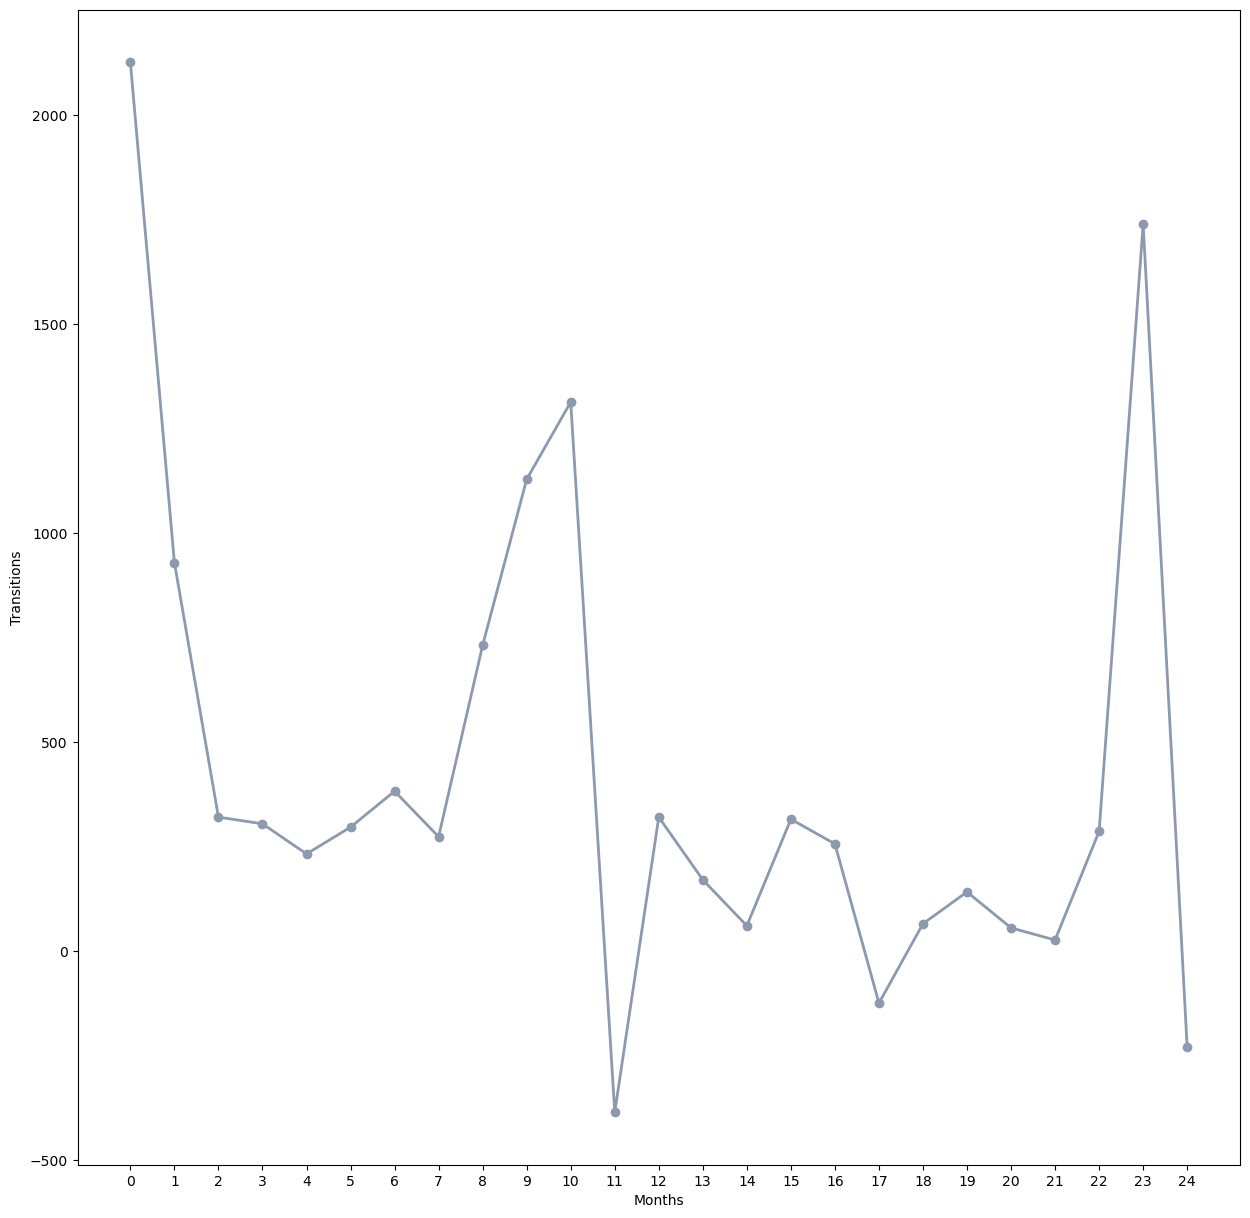

In [32]:
# RFM clustering graph
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot()
ax.set_xlabel("Months")
ax.set_ylabel("Transitions")
markers = ['*', '.', 'o', '+']
x = [i for i in range(25)]

ax.scatter(x, transitions, color='#8D99AE')
ax.plot(x ,transitions, linewidth=2, color='#8D99AE')

plt.xticks(x)
# ax.legend()
plt.show()